In [2]:
## Notebook to train the model using prepared Audioset data.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  ## to use CPU
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress

In [3]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]
    rec_len = len(records)
    print('rec_len',rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    subset_labels = [4,13,53,69,70,71,112,113,318,326,327,344,348,351,352,500]
    ## merging classes to create 5 major classes
    crowd =  [4, 13, 53, 69, 70, 71]
    birds = [112, 113]
    vehicles_passing = [318,326,344,348,351,352]
    ambient_traffic = [327]
    silence = [500]
    
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))              
                
            label_no = next(x for x in example_label if x in subset_labels)
            
            if label_no in crowd:
                y.append(0)
            if label_no in birds:
                y.append(1)
            if label_no in vehicles_passing:
                y.append(2)
            if label_no in ambient_traffic:
                y.append(3)
            if label_no in silence:
                y.append(4)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)

            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]

            audio_frame += pad

            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers

lstm3_model = Sequential()
lstm3_model.add(BatchNormalization(input_shape=(None, 128)))
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))


lstm3_model.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
lstm3_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
from keras.utils import plot_model
plot_model(lstm3_model, to_file='model.png')

In [6]:
lstm3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total para

In [7]:
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)

lstm3_model.summary(print_fn=myprint)

In [8]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'Data/train_subset_latest_4.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'Data/train_subset_latest_4.tfrecord', 1-CV_frac, 1)

rec_len = 44721

##modify epochs

lstm3_h = lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=2, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=2, callbacks=[TQDMNotebookCallback()])

Epoch 1/2


rec_len 44721
rec_len 4970
 - 20s - loss: 3.4372 - acc: 0.7318 - val_loss: 1.4317 - val_acc: 0.8844
Epoch 2/2


 - 18s - loss: 0.7630 - acc: 0.8599 - val_loss: 0.8515 - val_acc: 0.8945



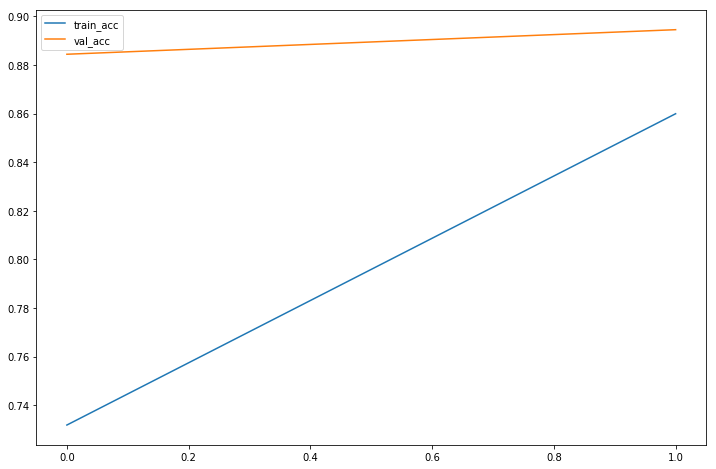

In [9]:
plt.plot(lstm3_h.history['acc'], label='train_acc')
plt.plot(lstm3_h.history['val_acc'], label='val_acc')
# plt.plot(lstm3_h.history['loss'], label='loss')
plt.legend()

In [16]:
# lstm3_model.save('Data/Trained_model_LSTM_2.h5')